In [34]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL



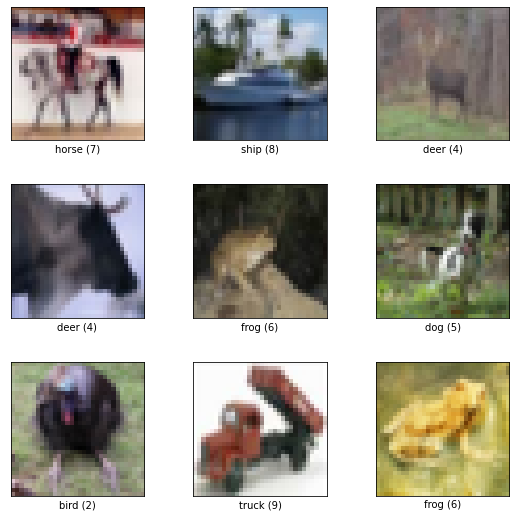

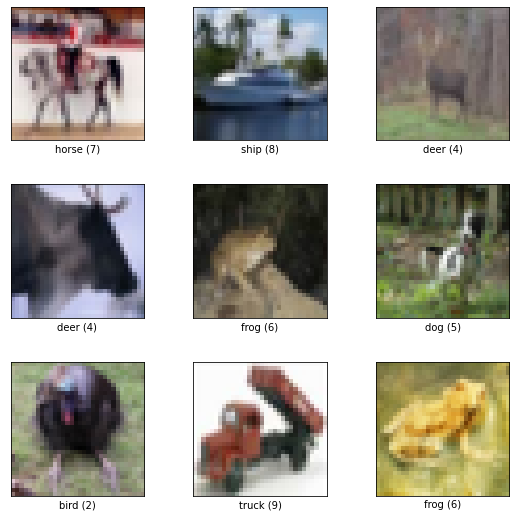

In [35]:
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

tfds.show_examples(train_ds, ds_info)

In [47]:
class BasicConv(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam(), dropout_rate=None, batch_norm=False, label_smoothing=False, regulizer=False):
        super(BasicConv, self).__init__()

        self.batch_norm = batch_norm
        self.optimizer = optimizer
        self.dropout = dropout_rate is not None

        if self.dropout:
          self.dropout_layer1 = tf.keras.layers.Dropout(dropout_rate)
          self.dropout_layer2 = tf.keras.layers.Dropout(dropout_rate)
          self.dropout_layer3 = tf.keras.layers.Dropout(dropout_rate)
          self.dropout_layer4 = tf.keras.layers.Dropout(dropout_rate)
        
        if batch_norm:
          self.batch_normalization1 = tf.keras.layers.BatchNormalization()
          self.batch_normalization2 = tf.keras.layers.BatchNormalization()
          self.batch_normalization3 = tf.keras.layers.BatchNormalization()
          self.batch_normalization4 = tf.keras.layers.BatchNormalization()

        label_smoothing_val = label_smoothing if label_smoothing else 0.0
        self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing_val)
        self.metrics_list = [[tf.keras.metrics.CategoricalAccuracy(name="test_accuracy"),
                             tf.keras.metrics.Mean(name="test_loss"),
                             tf.keras.metrics.Mean(name="test_frob_norm")],
                             [tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
                             tf.keras.metrics.Mean(name="train_loss"),
                             tf.keras.metrics.Mean(name="train_frob_norm")]]

        if regulizer:
          self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros', kernel_regularizer='l1_l2', activity_regularizer='l1', bias_regularizer=tf.keras.regularizers.L2(0.03))
          self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros', kernel_regularizer='l1_l2', activity_regularizer='l1', bias_regularizer=tf.keras.regularizers.L2(0.03))
        else:
          self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros')
          self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros')
  
        self.pooling = tf.keras.layers.MaxPooling2D()

        if regulizer:
          self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros', kernel_regularizer='l1_l2', activity_regularizer='l1', bias_regularizer=tf.keras.regularizers.L2(0.03))
          self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros', kernel_regularizer='l1_l2', activity_regularizer='l1', bias_regularizer=tf.keras.regularizers.L2(0.03))
        else:
          self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros')
          self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='zeros')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, x, training=False):
        x = self.convlayer1(x)

        if training and self.batch_norm:
          x = self.batch_normalization1(x)

        if training and self.dropout:
          x = self.dropout_layer1(x)
        
        x = self.convlayer2(x)
        x = self.pooling(x)        
        x = self.convlayer3(x)

        if training and self.batch_norm:
          x = self.batch_normalization2(x)
        if training and self.dropout:
          x = self.dropout_layer2(x)

        x = self.convlayer4(x)
        x = self.global_pool(x)

        if training and self.batch_norm:
          x = self.batch_normalization3(x)
        if training and self.dropout:
          x = self.dropout_layer3(x)

        x = self.dense1(x)

        if training and self.batch_norm:
          x = self.batch_normalization4(x)
        if training and self.dropout:
          x = self.dropout_layer4(x)

        x = self.out(x)
        return x

    @tf.function
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm

    # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list

    # 4. reset all metrics objects
    def reset_metrics(self, num):
        for metric in self.metrics[num]:
            metric.reset_states()


    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update metrics
        self.metrics_list[1][0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[1][1].update_state(loss)
        self.metrics_list[1][2].update_state(self.compute_frobenius())
        
        # return a dict with metric information
        return {m.name : m.result() for m in self.metrics_list[1]}

    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # update metrics
        self.metrics_list[0][0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[0][1].update_state(loss)
        self.metrics_list[0][2].update_state(self.compute_frobenius())

        # return a dict with metric information 
        return {m.name : m.result() for m in self.metrics_list[0]}

In [37]:

def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

In [38]:
def prepare_cifar10_data(cifar10, batch_size, augmentation=None, repeat=None):
    #convert data from uint8 to float32
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    cifar10 = cifar10.map(lambda img, target: ((img/128.)-1., target))
    #create one-hot targets
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    if augmentation:
      if repeat:
        cifar10 = cifar10.concatenate(cifar10.repeat(repeat)) # keep original
      cifar10 = cifar10.map(lambda img, label : (augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

    cifar10 = cifar10.cache()
    cifar10 = cifar10.shuffle(4096)
    cifar10 = cifar10.batch(batch_size)
    cifar10 = cifar10.prefetch(tf.data.AUTOTUNE)

    return cifar10

# trains the model by iterating through the dataset and applying training_step method epochs time
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, memory):
    metrics = []

    # iterate over epochs
    for epoch in tqdm(range(epochs)):

        # train steps on all batches in the training data
        for (img, label) in train_ds:
            metrics = model.train_step((img, label))
            
            # keep data in summary with metrics
            with train_summary_writer.as_default():
                for metric in model.metrics_list[1]:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        for (key, value) in metrics.items():
            memory[key].append(value.numpy())

        memory = test_loop(model=model,
                           test_ds=test_ds,
                           val_summary_writer=val_summary_writer,
                           memory=memory)
        
        # print current metric values and reset the metrics
        tf.print([f"{key} : {value.numpy()}" for (key, value ) in metrics.items()])
        model.reset_metrics(1)

    return memory


# tests overall performance of model
def test_loop(model, test_ds, val_summary_writer, memory):
    metrics = []
    # test steps on every item in test dataset
    for (img, label) in tqdm(test_ds):
        metrics = model.test_step((img, label))
        
        # keep data with metrics
        with val_summary_writer.as_default():
            for metric in model.metrics_list[0]:
                tf.summary.scalar(f"{metric.name}", metric.result(), step=1)

    for (key, value) in metrics.items():
        memory[key].append(value.numpy())

    print([f"{key} : {value.numpy()}" for (key, value ) in metrics.items()])

    model.reset_metrics(0)

    return memory

# visualize accuracy, loss and frobenius norm
def visualization(accuracies, losses, frobenius, name):
    plt.figure()
    line1, = plt.plot(accuracies, "b")
    line2, = plt.plot(losses, "r")

    frob_new = frobenius/np.max(frobenius) * np.max(losses)
    line3, = plt.plot(frob_new, "y" )

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3),("Accuracy", "Loss", "Frobenius Norm"))
    plt.savefig(name)
    plt.show()



In [60]:
# overall hyperparameters to compare with and without overfitting precautions methods
epochs = 15
batch_size = 32

## no augmentation, normal model

In [40]:
train_summary_writer, val_summary_writer = create_summary_writers(config_name="UNTOUCHED")

model = BasicConv()
train_dataset = train_ds.apply(lambda ds: prepare_cifar10_data(ds, batch_size))
val_dataset = val_ds.apply(lambda ds: prepare_cifar10_data(ds, batch_size))

  0%|          | 1/782 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 6642.96 ex/sec (total: 50048 ex, 7.53 sec)
Examples/sec (First only) 104.01 ex/sec (total: 64 ex, 0.62 sec)
Examples/sec (First excluded) 7224.53 ex/sec (total: 49984 ex, 6.92 sec)

************ Training UNTOUCHED ************



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.36942675709724426', 'test_loss : 1.4614722728729248', 'test_frob_norm : 66.58631896972656']
['train_accuracy : 0.30562660098075867',
 'train_loss : 1.6621664762496948',
 'train_frob_norm : 62.91448211669922']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.4331210255622864', 'test_loss : 1.2382936477661133', 'test_frob_norm : 72.44661712646484']
['train_accuracy : 0.4475703239440918',
 'train_loss : 1.275073528289795',
 'train_frob_norm : 69.67545318603516']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.5414012670516968', 'test_loss : 1.03255033493042', 'test_frob_norm : 77.0214614868164']
['train_accuracy : 0.572890043258667',
 'train_loss : 1.1142163276672363',
 'train_frob_norm : 74.83455657958984']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.5159235596656799', 'test_loss : 1.0802125930786133', 'test_frob_norm : 80.74812316894531']
['train_accuracy : 0.6061381101608276',
 'train_loss : 1.0182691812515259',
 'train_frob_norm : 78.91790008544922']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.675159215927124', 'test_loss : 0.9353874921798706', 'test_frob_norm : 84.03703308105469']
['train_accuracy : 0.6572890281677246',
 'train_loss : 0.9442972540855408',
 'train_frob_norm : 82.41140747070312']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.6178343892097473', 'test_loss : 0.916472315788269', 'test_frob_norm : 87.14258575439453']
['train_accuracy : 0.7135549783706665',
 'train_loss : 0.8841820359230042',
 'train_frob_norm : 85.6182632446289']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.7388535141944885', 'test_loss : 0.8455569744110107', 'test_frob_norm : 90.04366302490234']
['train_accuracy : 0.7199488282203674',
 'train_loss : 0.837238609790802',
 'train_frob_norm : 88.60919189453125']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.7452229261398315', 'test_loss : 0.806256115436554', 'test_frob_norm : 92.77635955810547']
['train_accuracy : 0.6867007613182068',
 'train_loss : 0.7904992699623108',
 'train_frob_norm : 91.39798736572266']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.675159215927124', 'test_loss : 0.8077089786529541', 'test_frob_norm : 95.40402221679688']
['train_accuracy : 0.7250639200210571',
 'train_loss : 0.7497949004173279',
 'train_frob_norm : 94.06751251220703']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.7197452187538147', 'test_loss : 0.7743970155715942', 'test_frob_norm : 98.05760955810547']
['train_accuracy : 0.7237851619720459',
 'train_loss : 0.7207263708114624',
 'train_frob_norm : 96.737060546875']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.8025477528572083', 'test_loss : 0.7664401531219482', 'test_frob_norm : 100.56056213378906']
['train_accuracy : 0.7480818629264832',
 'train_loss : 0.6845832467079163',
 'train_frob_norm : 99.30545043945312']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.662420392036438', 'test_loss : 0.7438473701477051', 'test_frob_norm : 103.05853271484375']
['train_accuracy : 0.7838874459266663',
 'train_loss : 0.6591577529907227',
 'train_frob_norm : 101.7952880859375']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.7133758068084717', 'test_loss : 0.7486702799797058', 'test_frob_norm : 105.42401123046875']
['train_accuracy : 0.7800511717796326',
 'train_loss : 0.6321461200714111',
 'train_frob_norm : 104.22616577148438']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.7324841022491455', 'test_loss : 0.7065982222557068', 'test_frob_norm : 107.74237060546875']
['train_accuracy : 0.8005114793777466',
 'train_loss : 0.6076517701148987',
 'train_frob_norm : 106.62384796142578']


  0%|          | 0/157 [00:00<?, ?it/s]

['test_accuracy : 0.6815286874771118', 'test_loss : 0.7590571045875549', 'test_frob_norm : 109.95014190673828']
['train_accuracy : 0.7851662635803223',
 'train_loss : 0.583461344242096',
 'train_frob_norm : 108.84294891357422']


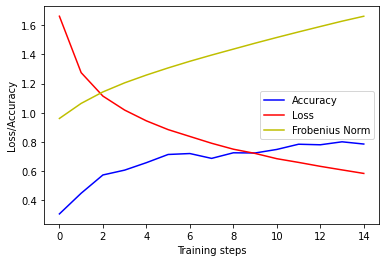

In [41]:
tfds.benchmark(train_dataset, batch_size=batch_size)

print("\n************ Training UNTOUCHED ************\n")

memory = {"test_accuracy" : [],
          "test_loss" : [],
          "test_frob_norm" : [],
          "train_accuracy" : [],
          "train_loss" : [],
          "train_frob_norm" : []
          }

memory = training_loop(model,
                       train_ds=train_dataset,
                       test_ds=val_dataset,
                       epochs=tf.constant(epochs),
                       train_summary_writer=train_summary_writer,
                       memory=memory)

visualization(memory["train_accuracy"], memory["train_loss"], memory["train_frob_norm"], "aug_train")

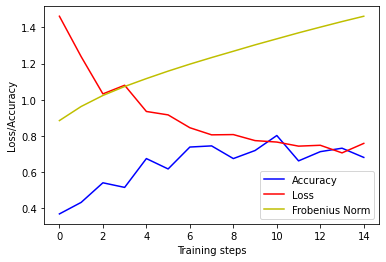

In [42]:
visualization(memory["test_accuracy"], memory["test_loss"], memory["test_frob_norm"], "aug_test")

## augmentation + regularizers + dropout + label smoothing + batchnormalization

In [66]:
train_summary_writer, val_summary_writer = create_summary_writers(config_name="FULL")

model = BasicConv(dropout_rate=0.1, batch_norm=True, label_smoothing=0.05, regulizer=True)
augmentation_model = tf.keras.Sequential([
  #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1)
])
train_dataset = train_ds.apply(lambda ds: prepare_cifar10_data(ds, batch_size, augmentation=augmentation_model, repeat=1))
val_dataset = val_ds.apply(lambda ds: prepare_cifar10_data(ds, batch_size))

  0%|          | 1/3125 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1581.07 ex/sec (total: 100000 ex, 63.25 sec)
Examples/sec (First only) 12.68 ex/sec (total: 32 ex, 2.52 sec)
Examples/sec (First excluded) 1646.27 ex/sec (total: 99968 ex, 60.72 sec)

************ Training optim-5 ************



  0%|          | 0/15 [00:18<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.11501597613096237', 'test_loss : 2.3026063442230225', 'test_frob_norm : 51.562686920166016']
['train_accuracy : 0.09440000355243683',
 'train_loss : 2.3034753799438477',
 'train_frob_norm : 52.18549346923828']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.07348243147134781', 'test_loss : 2.3026301860809326', 'test_frob_norm : 51.08495330810547']
['train_accuracy : 0.10239999741315842',
 'train_loss : 2.3029754161834717',
 'train_frob_norm : 51.22510528564453']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.11821085959672928', 'test_loss : 2.3026278018951416', 'test_frob_norm : 50.97655487060547']
['train_accuracy : 0.10175999999046326',
 'train_loss : 2.3028669357299805',
 'train_frob_norm : 51.02586364746094']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.10543131083250046', 'test_loss : 2.302625894546509', 'test_frob_norm : 50.875980377197266']
['train_accuracy : 0.10367999970912933',
 'train_loss : 2.3029215335845947',
 'train_frob_norm : 50.86857604980469']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.09265175461769104', 'test_loss : 2.3026235103607178', 'test_frob_norm : 50.85260009765625']
['train_accuracy : 0.1027199998497963',
 'train_loss : 2.3029282093048096',
 'train_frob_norm : 50.8413200378418']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.10543131083250046', 'test_loss : 2.3026113510131836', 'test_frob_norm : 50.84759521484375']
['train_accuracy : 0.1043199971318245',
 'train_loss : 2.302903175354004',
 'train_frob_norm : 50.80120849609375']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.08945687115192413', 'test_loss : 2.3026037216186523', 'test_frob_norm : 50.87884521484375']
['train_accuracy : 0.0995199978351593',
 'train_loss : 2.3028693199157715',
 'train_frob_norm : 50.86186981201172']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.10543131083250046', 'test_loss : 2.3026065826416016', 'test_frob_norm : 50.86126708984375']
['train_accuracy : 0.09440000355243683',
 'train_loss : 2.302905559539795',
 'train_frob_norm : 50.79533386230469']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.09584664553403854', 'test_loss : 2.3026247024536133', 'test_frob_norm : 50.8603630065918']
['train_accuracy : 0.10496000200510025',
 'train_loss : 2.302929639816284',
 'train_frob_norm : 50.827903747558594']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.10862620174884796', 'test_loss : 2.3026134967803955', 'test_frob_norm : 50.900638580322266']
['train_accuracy : 0.09888000041246414',
 'train_loss : 2.302896022796631',
 'train_frob_norm : 50.81755447387695']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.11821085959672928', 'test_loss : 2.3026082515716553', 'test_frob_norm : 50.83672332763672']
['train_accuracy : 0.10080000013113022',
 'train_loss : 2.302886724472046',
 'train_frob_norm : 50.881385803222656']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.1405750811100006', 'test_loss : 2.302625894546509', 'test_frob_norm : 50.76249313354492']
['train_accuracy : 0.10080000013113022',
 'train_loss : 2.3029167652130127',
 'train_frob_norm : 50.82688903808594']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.1277955323457718', 'test_loss : 2.3026061058044434', 'test_frob_norm : 50.87504577636719']
['train_accuracy : 0.09567999839782715',
 'train_loss : 2.302879810333252',
 'train_frob_norm : 50.80462646484375']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.10543131083250046', 'test_loss : 2.302635669708252', 'test_frob_norm : 50.8749885559082']
['train_accuracy : 0.09440000355243683',
 'train_loss : 2.3029026985168457',
 'train_frob_norm : 50.77064514160156']


  0%|          | 0/313 [00:00<?, ?it/s]

['test_accuracy : 0.08306708931922913', 'test_loss : 2.3026208877563477', 'test_frob_norm : 50.844932556152344']
['train_accuracy : 0.09824000298976898',
 'train_loss : 2.3029003143310547',
 'train_frob_norm : 50.842926025390625']


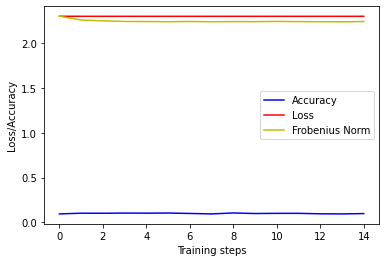

In [67]:
tfds.benchmark(train_dataset, batch_size=batch_size)

print("\n************ Training optim-5 ************\n")

memory = {"test_accuracy" : [],
          "test_loss" : [],
          "test_frob_norm" : [],
          "train_accuracy" : [],
          "train_loss" : [],
          "train_frob_norm" : []
          }

memory = training_loop(model,
                       train_ds=train_dataset,
                       test_ds=val_dataset,
                       epochs=tf.constant(epochs),
                       train_summary_writer=train_summary_writer,
                       memory=memory)

visualization(memory["train_accuracy"], memory["train_loss"], memory["train_frob_norm"], "aug_train")

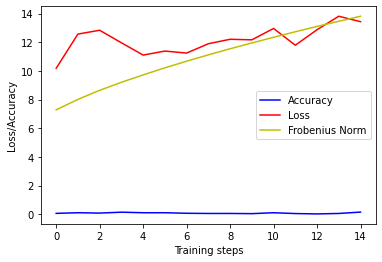

In [45]:
visualization(memory["test_accuracy"], memory["test_loss"], memory["test_frob_norm"], "aug_test")

Our original model had no problems with the dataset and did not overfit. So we added a layer. Using the optimization methods, the model now overfits and performs way worse than ever before. We tried different ways of applying the methods including many parameters but a combination of everything always leads to this result.

Unfortunately, Google Colab limits the use of GPU Accelerators so we could not test permutation of the methods... We worked through our Google Accounts and are waiting to get our GPUs back...